# Separation of CIFAR-10 Images

The model takes as input an image created by averaging two random samples from CIFAR-10 and is tasked with predicting the categories of the two components.

The first image belongs to the first five categories (airplane, automobile, bird, cat, deer), while the second belongs to the remaining categories (dog, frog, horse, ship, truck). The model must return two labels, each within a range of five possible values.

The evaluation metric for the model is as follows: calculate the classification accuracy for the two component images and then compute their average.

The metric should be evaluated on 10,000 inputs generated from test data. Repeat the calculation 10 times and measure the standard deviation, which must be reported.

A data generator and some examples are provided below.

# Data preparation

In [36]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import backend as K
import numpy as np
from matplotlib import pyplot as plt

In [2]:
img_dim = 32
num_channels = 3
num_classes_per_output = 5

In [3]:
(cifar10_x_train, cifar10_y_train), (cifar10_x_test, cifar10_y_test) = cifar10.load_data()
assert cifar10_x_train.shape == (50000, img_dim, img_dim, num_channels)
assert cifar10_x_test.shape == (10000, img_dim, img_dim, num_channels)
assert cifar10_y_train.shape == (50000, 1)
assert cifar10_y_test.shape == (10000, 1)

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

cifar10_x_train = (cifar10_x_train/255.).astype(np.float32)
cifar10_x_test = (cifar10_x_test/255.).astype(np.float32)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Let us split the images in two groups, according to their label.

In [4]:
cond_1 = cifar10_y_train[:,0] < num_classes_per_output
cifar10_x_train_1 = cifar10_x_train[cond_1]
cifar10_y_train_1 = cifar10_y_train[cond_1]

cond_2 = cifar10_y_train[:,0] >= num_classes_per_output
cifar10_x_train_2 = cifar10_x_train[cond_2]
cifar10_y_train_2 = cifar10_y_train[cond_2]

cond_1_test = cifar10_y_test[:,0] < num_classes_per_output
cifar10_x_test_1 = cifar10_x_test[cond_1_test]
cifar10_y_test_1 = cifar10_y_test[cond_1_test]

cond_2_test = cifar10_y_test[:,0] >= num_classes_per_output
cifar10_x_test_2 = cifar10_x_test[cond_2_test]
cifar10_y_test_2 = cifar10_y_test[cond_2_test]

Let's check the size of the splits

In [5]:
print(f"Train split 1 shape: {cifar10_x_train_1.shape} containing the classes airplane, automobile, bird, cat and deer")
print(f"Test split 1 shape: {cifar10_x_test_1.shape} containing the classes airplane, automobile, bird, cat and deer")

print(f"Train split 2 shape: {cifar10_x_train_2.shape} containing the classes dog, frog, horse, ship and truck")
print(f"Test split 2 shape: {cifar10_x_test_2.shape} containing the classes dog, frog, horse, ship and truck")

Train split 1 shape: (25000, 32, 32, 3) containing the classes airplane, automobile, bird, cat and deer
Test split 1 shape: (5000, 32, 32, 3) containing the classes airplane, automobile, bird, cat and deer
Train split 2 shape: (25000, 32, 32, 3) containing the classes dog, frog, horse, ship and truck
Test split 2 shape: (5000, 32, 32, 3) containing the classes dog, frog, horse, ship and truck


Visualize one image for each training set split

Image dimension: 32x32


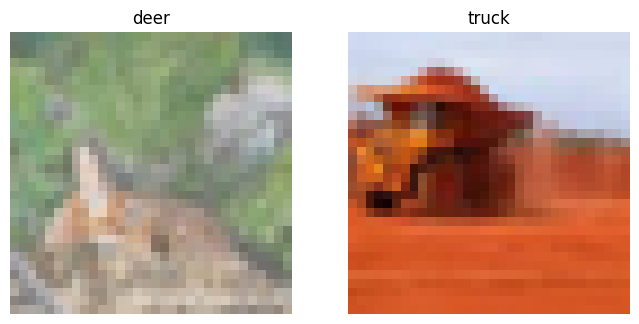

In [6]:
print(f"Image dimension: {img_dim}x{img_dim}")

rnd_idx_1 = np.random.randint(0, cifar10_x_train_1.shape[0])
rnd_idx_2 = np.random.randint(0, cifar10_x_train_2.shape[0])

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.imshow(cifar10_x_train_1[rnd_idx_1])
plt.title(classes[cifar10_y_train_1[rnd_idx_1][0]])
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cifar10_x_train_2[rnd_idx_2])
plt.title(classes[cifar10_y_train_2[rnd_idx_2][0]])
plt.axis('off')

plt.show()

Now we can define the generator. The input consists of two datasets (X1,X2), their corresponding labels (Y1,Y2), and a batch size.

The generator returns (x_data,y_data), where:
* x_data is a batch of images obtained by averaging random samples from X1 and X2.
* y_data is a pair of batches of labels corresponding to the component images, expressed in categorical format. Note that, in order to use this generator in the ["fit" method of keras](https://keras.io/api/models/model_training_apis/), we have to output a tuple for the output instead of a list.

In [7]:
def datagenerator(X1,X2,Y1,Y2,batchsize):
  size1 = X1.shape[0]
  size2 = X2.shape[0]
  Y1_cat = tf.keras.utils.to_categorical(Y1, num_classes=num_classes_per_output)
  Y2_cat = tf.keras.utils.to_categorical(Y2-num_classes_per_output, num_classes=num_classes_per_output)

  while True:
    num1 = np.random.randint(0, size1, batchsize)
    num2 = np.random.randint(0, size2, batchsize)
    x_data = (X1[num1] + X2[num2]) / 2.0
    y_data = (Y1_cat[num1],Y2_cat[num2])

    yield x_data, y_data


Let us instantiate a generator on Cifar10 with batchsize=1 and observe its behaviour.

In [8]:
datagen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,1)

In [9]:
x,y = next(datagen)
print(f"Generated x shape: {x.shape}")
print(f"Generated y shape: ({len(y)}, 1, {num_classes_per_output})")

print(f"First entry of the tuple y: {y[0]} ")
print(f"Second entry of the tuple y: {y[1]} ")

Generated x shape: (1, 32, 32, 3)
Generated y shape: (2, 1, 5)
First entry of the tuple y: [[0. 0. 0. 0. 1.]] 
Second entry of the tuple y: [[0. 0. 1. 0. 0.]] 


Let's generate an example, display the image that the model will take as input, and print the categories of the two overlapping components.

You can re-run the cell to display new examples.

first: deer, second = frog


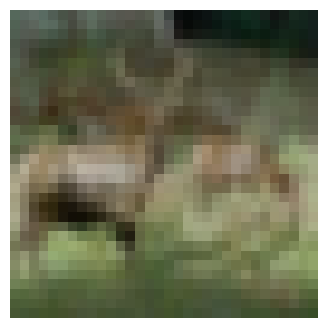

In [10]:
x, y = next(datagen)

print("first: {}, second = {}".format(classes[np.argmax(y[0][0])],classes[np.argmax(y[1][0])+5]))
plt.figure(figsize=(4,4))
plt.imshow(x[0])
plt.axis('off')
plt.show()

# Model Definition

In [11]:
import keras
from keras import ops

In [12]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [13]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]

        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size

        # dimension = (#images, num_ph, num_pw, patch_size*patch_size*n_channels)
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)

        #Flatten the spatial dimensions
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

Let's take a look at the effect of the Patches layer we have created above. It is supposed to divide the image in patches in order to be processed by the visual transformer.

Image size: 32 X 32
Patch size: 4 X 4
Images in batch: 2
Patches per image: 64
Elements per patch: 48


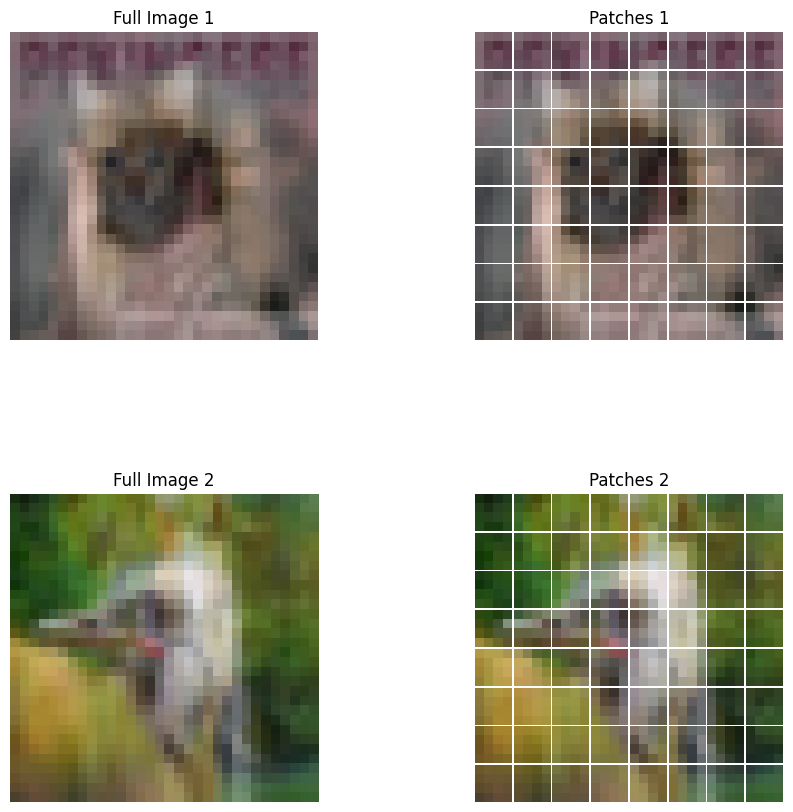

In [14]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

patch_size = 4

x1, _ = next(datagen)
x2, _ = next(datagen)
images = np.concatenate((x1, x2), axis=0)

patches = Patches(patch_size)(images)
imgs_in_batch = patches.shape[0]

print(f"Image size: {img_dim} X {img_dim}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Images in batch: {imgs_in_batch}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))

# Create a figure with GridSpec
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(imgs_in_batch, 2, hspace=0.5, wspace=0.5)

for img_idx in range(imgs_in_batch):
    # Full image
    ax_full = fig.add_subplot(gs[img_idx, 0])
    ax_full.imshow(images[img_idx])
    ax_full.set_title(f"Full Image {img_idx + 1}")
    ax_full.axis("off")

    # Patches
    spacing = 0.2
    ax_patches = fig.add_subplot(gs[img_idx, 1])
    ax_patches.set_xlim(0, n * (patch_size + spacing) - spacing)
    ax_patches.set_ylim(n * (patch_size + spacing) - spacing, 0)
    ax_patches.axis("off")
    ax_patches.set_title(f"Patches {img_idx + 1}")

    for i, patch in enumerate(patches[img_idx]):
        row, col = divmod(i, n)
        patch_img = ops.reshape(patch, (patch_size, patch_size, 3))

        # Calculate position with spacing
        left = col * (patch_size + spacing)
        right = left + patch_size
        top = row * (patch_size + spacing)
        bottom = top + patch_size

        # Plot each patch with spacing
        ax_patches.imshow(patch_img, extent=[left, right, bottom, top])

We need our embedding layer for the batches in order to encode them, and we have to take into account the position of the patch too.

In [15]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

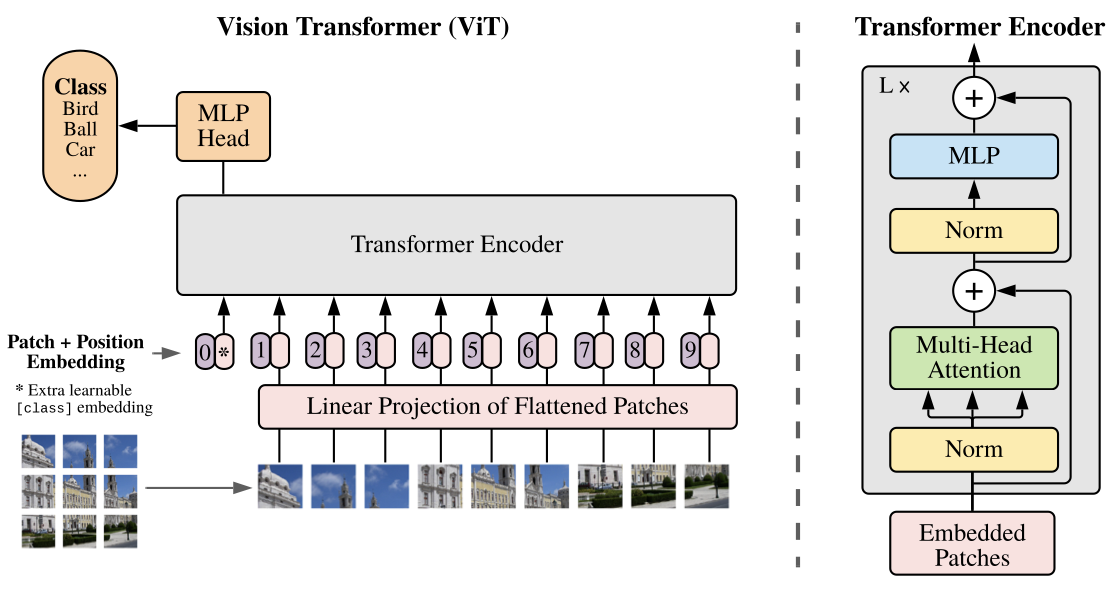

We now build the ViT architecture by taking as a reference the image above (from the paper [AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE](https://arxiv.org/abs/2010.11929))  

In [16]:
def create_vit_classifier():
    inputs = keras.Input(shape=(img_dim, img_dim,num_channels))

    # Create patches
    patches = Patches(patch_size)(inputs)

    # Encode patches (i.e. embed them)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        # Create a multi-head attention layer
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim
        )(x1, x1)

        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.1)(representation)

    # Specialized heads for the classification
    features_im1 = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.1)
    features_im2 = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.1)

    # Classify outputs
    logits_im1 = layers.Dense(5)(features_im1)
    logits_im2 = layers.Dense(5)(features_im2)

    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=[logits_im1,logits_im2])
    return model

Now we manually set some hyperparameters, but we will tune them later.

In [17]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 250
steps_per_epoch = 20

patch_size = 4
num_patches = (img_dim // patch_size) ** 2

projection_dim = 64
num_heads = 4

transformer_units = [
    projection_dim * 2,
    projection_dim,
]

transformer_layers = 8

mlp_head_units = [
    #2048,
    #1024,
    512,
    256,
]  # Size of the dense layers of the final classifier

train_datagen = datagenerator(cifar10_x_train_1,cifar10_x_train_2,cifar10_y_train_1,cifar10_y_train_2,batch_size)

In [18]:
def plot_history(history, item):
    plt.plot(history.history[item], label=item)
    #plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

For the moment let's create our ViT based on the hyperparameters set above.

In [19]:
vit_classifier = create_vit_classifier()

In [20]:
def averaged_categorical_crossentropy(y_true, y_pred):
  y_true_1, y_true_2 = y_true
  y_pred_1, y_pred_2 = y_pred

  loss_1 = tf.keras.losses.CategoricalCrossentropy(from_logits = True)(y_true_1, y_pred_1)
  loss_2 = tf.keras.losses.CategoricalCrossentropy(from_logits = True)(y_true_2, y_pred_2)

  return (loss_1 + loss_2) / 2.0

In [38]:
class MeanAccuracy(keras.metrics.Metric):
  def __init__(self, name, **kwargs):
    super().__init__(name=name, **kwargs)
    self.mean_acc_value = 0

  def update_state(self, y_true, y_pred):
    y_true_1, y_true_2 = y_true
    y_pred_1, y_pred_2 = y_pred

    correct_guesses_1 = K.argmax(y_pred_1, axis=1) == K.argmax(y_true_1, axis=1)
    correct_guesses_2 = K.argmax(y_pred_2, axis=1) == K.argmax(y_true_2, axis=1)

    #Over the last batch
    self.mean_acc_value = (K.mean(correct_guesses_1) + K.mean(correct_guesses_2)) / 2.0

  def result(self):
    return self.mean_acc_value

  def reset_state(self):
    self.mean_acc_value = 0

In [21]:
def mean_accuracy(y_true, y_pred):
    y_true_1, y_true_2 = y_true
    y_pred_1, y_pred_2 = y_pred

    correct_guesses_1 = np.argmax(y_pred_1, axis=1) == np.argmax(y_true_1, axis=1)
    correct_guesses_2 = np.argmax(y_pred_2, axis=1) == np.argmax(y_true_2, axis=1)

    return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2)) / 2.0

In the first experiment we train our model without using a custom loss (we limit to categorical crossentropy), but in the next experiments we implement a custom loss which is supposed to catch the correlation between the two classifications since the image is generated as the average of the two.

### Categorical Crossentropy Training

Epoch 1/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 66s 93ms/step - dense_121_accuracy: 0.1910 - dense_121_loss: 3.1412 - dense_122_accuracy: 0.2024 - dense_122_loss: 2.9760 - loss: 6.1172
Epoch 2/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - dense_121_accuracy: 0.2006 - dense_121_loss: 1.6441 - dense_122_accuracy: 0.2004 - dense_122_loss: 1.6505 - loss: 3.2947
Epoch 3/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - dense_121_accuracy: 0.1983 - dense_121_loss: 1.6237 - dense_122_accuracy: 0.2090 - dense_122_loss: 1.6143 - loss: 3.2380
Epoch 4/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - dense_121_accuracy: 0.2052 - dense_121_loss: 1.6147 - dense_122_accuracy: 0.2289 - dense_122_loss: 1.6107 - loss: 3.2253
Epoch 5/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - dense_121_accuracy: 0.2328 - dense_121_loss: 1.6007 - dense_122_accuracy: 0.2188 - dense_122_loss: 1.6150 - loss: 3.2157
Epoch 6/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - dense_121_accuracy: 0.2688 - dense_121_loss: 1.5780 - dense_122_

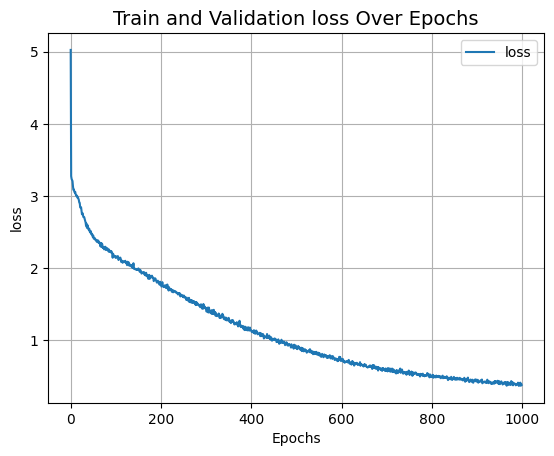

In [ ]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=[keras.losses.CategoricalCrossentropy(from_logits=True), keras.losses.CategoricalCrossentropy(from_logits=True)],
        metrics=['accuracy', 'accuracy'],
    )

    history = model.fit(train_datagen,
        batch_size=batch_size,
        steps_per_epoch = steps_per_epoch,
        epochs=num_epochs,
    )

    return history

#TODO Move this away
history = run_experiment(vit_classifier)
plot_history(history, "loss")

### Averaged Categorical Crossentropy Training

In [ ]:
def run_experiment_averaged_cce(model):
  optimizer = keras.optimizers.AdamW(
      learning_rate=learning_rate, weight_decay=weight_decay
  )

  hist = dict()
  hist['history'] = dict()
  hist['history']['loss'] = []
  hist['history']['accuracy'] = []

  for epoch in range(num_epochs):
      print("\nStart of epoch %d" % (epoch,))

      for step in range(steps_per_epoch):
          x_batch, y_batch = next(train_datagen)

          with tf.GradientTape() as tape:
              logits = model(x_batch, training=True)  # Logits for this minibatch
              loss_value = averaged_categorical_crossentropy(y_batch, logits)


          grads = tape.gradient(loss_value, model.trainable_weights)
          optimizer.apply_gradients(zip(grads, model.trainable_weights))

      print(f"Training loss (for one epoch): {loss_value}")
      hist['history']['loss'].append(loss_value)

      train_accuracy = mean_accuracy(y_batch, logits)
      hist['history']['accuracy'] = train_accuracy
      print(f"Training acc over epoch: {train_accuracy}")

  return hist

In [ ]:
run_experiment_averaged_cce(vit_classifier)


Start of epoch 0
Training loss (for one epoch): 1.7548301219940186
Training acc over epoch: 0.1953125

Start of epoch 1
Training loss (for one epoch): 1.6445159912109375
Training acc over epoch: 0.169921875

Start of epoch 2
Training loss (for one epoch): 1.6165242195129395
Training acc over epoch: 0.240234375

Start of epoch 3
Training loss (for one epoch): 1.5571043491363525
Training acc over epoch: 0.2734375

Start of epoch 4
Training loss (for one epoch): 1.5248775482177734
Training acc over epoch: 0.330078125

Start of epoch 5
Training loss (for one epoch): 1.53108549118042
Training acc over epoch: 0.326171875

Start of epoch 6
Training loss (for one epoch): 1.5113025903701782
Training acc over epoch: 0.32421875

Start of epoch 7
Training loss (for one epoch): 1.4627008438110352
Training acc over epoch: 0.341796875

Start of epoch 8
Training loss (for one epoch): 1.4898967742919922
Training acc over epoch: 0.33984375

Start of epoch 9
Training loss (for one epoch): 1.464048147201

### Creating a ViT as keras.model

In [57]:
class ViT_trainer(keras.Model):
  def __init__(self, vit):
    super().__init__()
    self.vit = vit
    self.seed_generator = keras.random.SeedGenerator(42)

  def compile(self, optimizer, loss_fn, metric_fn):
    super().compile()
    self.optimizer = optimizer
    self.loss_fn = loss_fn
    self.metric_fn = metric_fn

  @property
  def metrics(self):
    return [self.metric_fn]

  def train_step(self, data):
    x,y = data

    with tf.GradientTape() as tape:
      predictions = self.vit(x, training=True)
      loss = self.loss_fn(y, predictions)

    grads = tape.gradient(loss, self.vit.trainable_weights)
    self.optimizer.apply_gradients( zip(grads, self.vit.trainable_weights) )

    self.metric_fn.update_state(y, predictions)

    return {'loss:':loss, 'avg_accuracy:':self.metric_fn.result()}

  def test_step(self, data):
    x, y = data

    # Inference step
    y_pred = self.vit(x, training=False)

    self.metric_fn.update_state(y, y_pred)
    return {'avg_accuracy:':self.metric_fn.result()}

  def call(self, x):
    # Equivalent to `call()` of the wrapped keras.Model
    y = self.vit(x)
    return y


In [65]:
def run_vit_trainer_experiment(model):
  vit_trainer = ViT_trainer(model)

  optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

  vit_trainer.compile(optimizer, averaged_categorical_crossentropy, MeanAccuracy('mean_accuracy'))

  history = vit_trainer.fit(train_datagen,
                            batch_size=batch_size,
                            steps_per_epoch = steps_per_epoch,
                            epochs=num_epochs,
                            validation_split=0.1
                        )
  return history, model

In [66]:
tmp = run_vit_trainer_experiment(vit_classifier)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 79ms/step - avg_accuracy:: 0.8241 - loss:: 0.4721
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - avg_accuracy:: 0.8324 - loss:: 0.4513
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - avg_accuracy:: 0.8441 - loss:: 0.4299
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - avg_accuracy:: 0.8348 - loss:: 0.4514
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - avg_accuracy:: 0.8362 - loss:: 0.4428
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - avg_accuracy:: 0.8356 - loss:: 0.4394
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - avg_accuracy:: 0.8443 - loss:: 0.4325
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - avg_accuracy:: 0.8397 - loss:: 0.4334
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - avg_accuracy:: 0.8422 - loss:: 0.4314
Epoch 10/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - avg_accuracy:: 0.8358 - loss:: 0.4463
Epoch 11/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - avg_accuracy:: 0.8357 - loss:: 0.4

In [68]:
hist, m = tmp

# Model Evaluation

Let us define first of all the test generator.

In [58]:
testgen = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,10000)

eval_samples_x, eval_samples_y = next(testgen)
print(eval_samples_x.shape)

(10000, 32, 32, 3)


We now test a model producing random guesses. You will need to replace it with your own predictive model.

In [ ]:
def random_model(x):
  #the random model ingnore the input x and return a pair of random classes
  return(np.random.randint(0,5,(10000,2)))

In [69]:
def vit_predict(x):
  return m.predict(x)

In [60]:
def eval_model(model):
  eval_samples_x, eval_samples_y = next(testgen)
  random_guesses = model(eval_samples_x)
  correct_guesses_1 = np.argmax(random_guesses[0],axis=1) == np.argmax(eval_samples_y[0],axis=1)
  correct_guesses_2 = np.argmax(random_guesses[1],axis=1) == np.argmax(eval_samples_y[1],axis=1)
  return (np.mean(correct_guesses_1) + np.mean(correct_guesses_2))/2

In [70]:
eval_model(vit_predict)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


0.62775

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Real - first: airplane, second = ship
Predicted - first: airplane, second = dog


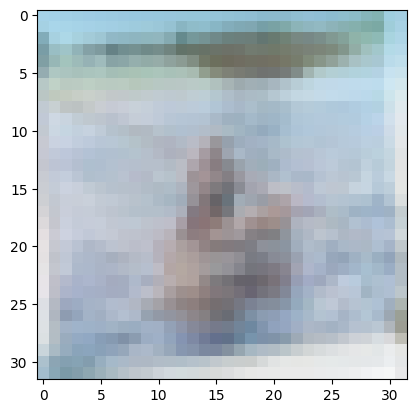

In [71]:
testgen1 = datagenerator(cifar10_x_test_1,cifar10_x_test_2,cifar10_y_test_1,cifar10_y_test_2,1)
x, y = next(datagen)

guesses = vit_predict(x)
guess1 = classes[np.argmax(guesses[0],axis=1)[0]]
guess2 = classes[np.argmax(guesses[0],axis=1)[0]+5]

print("Real - first: {}, second = {}".format(classes[np.argmax(y[0][0])],classes[np.argmax(y[1][0])+5]))
#print(np.min(x[0]),np.max(x[0]))
plt.imshow(x[0])
print("Predicted - first: {}, second = {}".format(guess1,guess2))

As expected, the accuracy is around 1/5 = 0.2

Let us repeat the evaluation ten times, and compute the standard deviation

In [72]:
repeat_eval = 10
eval_results = []
for i in range(repeat_eval):
  eval_results.append(eval_model(vit_predict))
print("mean accuracy = ", np.mean(eval_results))
print("standard deviation = ", np.std(eval_results))

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
mean accuracy =  0.627785
standard deviation =  0.00300300266400146


In [ ]:
vit_classifier.save_weights('model_weights_acce1.weights.h5')

NameError: name 'vit_classifier' is not defined

In [ ]:
vit_classifier.save()

# What to Submit

As usual, you need to submit a single notebook that must be executable on Colab. The notebook should be properly commented and include a complete record of the training process, as well as the calculation of accuracy according to the guidelines provided above.

# Good luck!

